<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c620_Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install autorch > log.txt

In [36]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
pd.options.display.max_rows = 999

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c620_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c620_col_names.pkl')
df.head(3)

,Combined Feed to Tatoray Stripper C620_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Tatoray Stripper C620_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,...,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Hexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Benzene_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Cyclohexane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_n-Heptane_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Water_Fraction,Tatoray Stripper C620 Split Factors Calculation_Split Factor for Individual Component to Tatoray Stripper C620 Bottoms_Methylcyclohexane_Fraction,Tatoray Stri

# 建立 f(case,input_wt,op) = output_wt

In [37]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']
n_idx = [ [i,i+41,i+41*2,i+41*3] for i in range(41)]

  1%|          | 1/100 [00:00<01:03,  1.57it/s]

epoch:0 train_loss:0.0074 valid_loss:0.0013


 51%|█████     | 51/100 [00:31<00:30,  1.61it/s]

epoch:50 train_loss:0.0009 valid_loss:0.0009


100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


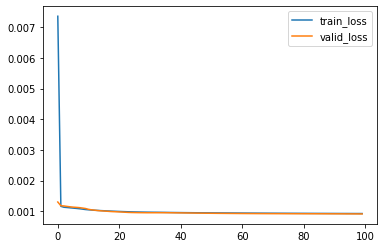

In [38]:
# train
c620_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=100,limit_y_range=True,normalize_idx_list=n_idx)
c620_f.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col+op_col),256),nn.Linear(256,256),nn.Linear(256,len(sp_col)),nn.Sigmoid())
c620_f.optimizer = Adam(c620_f.net.parameters(),lr=1e-3)
c620_f.train()

In [39]:
# test
x_test = c620_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c620_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
res = c620_f.show_metrics(wt_real,wt_pred)
res

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.976041,0.000329983,0.779669
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.972462,0.0912191,0.580041
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.958081,0.0150067,0.249664
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.968397,0.0352072,1.69341
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,0.947874,0.039858,4.64846
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,0.93405,0.000118024,3.78608
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,0.953249,0.0524435,2.13986
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,0.959376,1.14469e-07,1.99582
Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,0.987975,4.7457e-09,1.63737


In [40]:
res.loc[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,R2,MSE,MAPE
Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,0.996423,0.232343,0.483012


In [41]:
a = wt_pred[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']].head(10)
b = wt_real[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']].head(10)

In [42]:
b.columns = ['輸出端']
a.join(b)

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%,輸出端
035-079,70.633198,70.000000
083-009,89.800948,89.999992
137-048,69.793928,70.000008
107-014,80.189763,80.000000
022-101,90.297550,90.000015
075-056,89.965943,90.000000
115-027,69.693854,70.000000
071-064,79.707517,80.000008
139-030,89.487310,90.000008
094-051,69.664057,70.000008


In [43]:
def F(case,input_wt,op):
  sp = c620_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

In [44]:
path = '/content/drive/MyDrive/台塑輕油案子/data/c620/模擬擴充資料0514.xlsx'
df_extend = pd.read_excel(path)
idx_extend = df_extend.iloc[0,6:].values
case_extend = df_extend.iloc[[5,6,7],6:].T
case_extend.columns = case_col
case_extend.index = idx_extend
case_extend.head(1)

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%
2021-04-15,40.4029,0,74.55


In [45]:
wt_extend = df_extend.iloc[132:132+41,6:].T
wt_extend.columns = input_wt_col
wt_extend.index = idx_extend
wt_extend.head(1)

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
2021-04-15,0,0.0296863,0.719894,0.653423,0.183413,0.0765324,0.0159367,17.1791,0.00681777,0.0147861,0,0.0109084,37.2087,0.00727228,0.00856008,0.00856008,1.03071,7.28702,15.6964,6.67497,0.0124235,0.00965156,0.00234834,0.0118788,0.801822,0.420214,2.26218,0.236092,5.77757,0,0.922095,0.0415759,0.00115772,0.0254698,0.966693,0,1.11372,0.407516,0.174815,0,0


In [46]:
op_extend = df_extend.iloc[221:221+2,6:].T
op_extend.columns = op_col[-2:]
op_extend.index = idx_extend
op_extend.head(1)

,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
2021-04-15,180.12,195.408


In [47]:
G = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_G.pkl')

In [48]:
op_pred = G.predict(case_extend.join(wt_extend))
op_pred = pd.DataFrame(op_pred,columns=op_col,index=idx_extend)
op_pred[op_col[-2:]] = op_extend
op_extend = op_pred
op_extend.head(1)

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
2021-04-15,0.862296,0.441679,0.798045,0.879025,0.872057,120.861343,12.411498,14.290515,180.12,195.408


In [49]:
df_extend = case_extend.join(wt_extend).join(op_extend).astype('float32')
df_extend.head(1)

,Tatoray Stripper C620 Operation_Specifications_Spec 1 : Receiver Temp_oC,Tatoray Stripper C620 Operation_Specifications_Spec 2 : Distillate Rate_m3/hr,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_

  2%|▏         | 1/42 [00:00<00:20,  1.99it/s]

epoch:0 train_loss:0.0035 valid_loss:0.0006


100%|██████████| 42/42 [00:20<00:00,  2.06it/s]


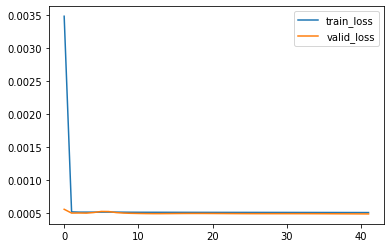

In [50]:
G = autorch.utils.PartBulider(df.append(df_extend),case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col),256),nn.Linear(256,256),nn.Linear(256,len(op_col)),nn.Sigmoid())
G.optimizer = Adam(G.net.parameters(),lr=1e-3)
G.train()

In [51]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.999836,2.41511e-10,0.00148073
Density_Vent Gas Production Rate and Composition,0.961663,8.69536e-07,0.153434
Density_Distillate Production Rate and Composition,0.927452,7.99082e-06,0.262556
Density_Sidedraw Production Rate and Composition,0.99536,5.23794e-09,0.00670822
Density_Bottoms Production Rate and Composition,0.996842,5.26554e-11,0.000701003
Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,0.983316,2.33854,0.758822
Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.987963,0.0153112,0.666674
Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.985747,0.0250689,0.685723
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,0.899304,0.128851,0.182361
Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC,0.991402,0.00663361,0.0297545


In [52]:
cond = (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] >= 69) & (df['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'] <= 71)
sample = df[cond].sample(10)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
F(case,input_wt,op)

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [53]:
sample[output_wt_col]

,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Water_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Tatoray Stripper C620 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Methane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Composition_Propane_wt%,Tatoray Stripper C620 Operation_Bottoms Production Rate and Com

In [54]:
sample['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']

081-090    70.000008
068-075    70.000008
102-049    70.000008
128-025    70.000000
067-077    70.000000
093-025    70.000008
042-099    70.000000
091-080    70.000000
030-050    70.000008
035-019    70.000008
Name: Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%, dtype: float64

# 數學規劃求解器

透過調整op 來讓 'Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'  == 70

In [55]:
!pip install optuna > log.txt

In [56]:
sample[input_wt_col]

,Combined Feed to Tatoray Stripper C620_Detailed Composition_Hydrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Propane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Butane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Benzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Cyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Heptane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Water_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Toluene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Octane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_p-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_m-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_o-Xylene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Nonane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_Indane_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Tatoray Stripper C620_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Tatoray Stripper C620_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Nitrogen_wt%,Combined Feed to Tatoray Stripper C620_Detailed Composition_Oxygen_wt%
081-090,0.0,0.018313,0.446701,0.413606,0.127286,0.068534,0.014021,16.186518,0.007267,0.014094,0.0,0.011480,46.251591,0.007654,0.009009,0.009009,0.734459,5.058490,10.719179,4.754348,0.013075,0.012056,0.002471,0.014724,0.993988,0.520967,2.803984,0.292647,7.162034,0.0,1.143349,0.051351,0.000736,0.019878,0.768705,0.0,0.885028,0.324397,0.139053,0.0,0.0
068-075,0.0,0.023233,0.561320,0.512709,0.148361,0.067386,0.013974,14.842036,0.006360,0.012882,0.0,0.010175,39.232159,0.006783,0.007985,0.007985,0.945686,7.385043,16.132347,6.608338,0.011588,0.005576,0.002190,0.006505,0.911681,0.477680,2.419997,0.268579,6.181028,0.0,0.986957,0.032527,0.000929,0.021375,0.835475,0.0,0.960936,0.246275,0.105945,0.0,0.0
102-049,0.0,0.018298,0.443738,0.412712,0.128530,0.071674,0.014892,1

In [57]:
sample[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]

,Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%
081-090,70.000008
068-075,70.000008
102-049,70.000008
128-025,70.000000
067-077,70.000000
093-025,70.000008
042-099,70.000000
091-080,70.000000
030-050,70.000008
035-019,70.000008


In [58]:
op_max = df.append(df_extend)[op_col].max().to_dict()
op_min = df.append(df_extend)[op_col].min().to_dict()

In [59]:
op_max

{'Density_Bottoms Production Rate and Composition': 0.8722013448663097,
 'Density_Distillate Production Rate and Composition': 0.8276968447728095,
 'Density_Feed Properties': 0.8646730162921348,
 'Density_Sidedraw Production Rate and Composition': 0.8816900667286587,
 'Density_Vent Gas Production Rate and Composition': 0.4596509754645822,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 181.28814697265625,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 195.40753173828125,
 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 15.352493044000001,
 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 17.330535890000007,
 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 151.33982849999998}

In [60]:
op_min

{'Density_Bottoms Production Rate and Composition': 0.8718550196589577,
 'Density_Distillate Production Rate and Composition': 0.7715259991981224,
 'Density_Feed Properties': 0.8620919983765354,
 'Density_Sidedraw Production Rate and Composition': 0.8786906178745657,
 'Density_Vent Gas Production Rate and Composition': 0.42652801816569175,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 174.52383419999998,
 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 191.5879211,
 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 10.416381362000001,
 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 12.03581238,
 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 97.02017975}

In [61]:
joblib.dump(op_max,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_max.pkl')
joblib.dump(op_min,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_min.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c620_op_min.pkl']

In [62]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端bz = sample[case_col]['Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%'].values
                                                                                        
  輸出端bz = F(sample[case_col],sample[input_wt_col],op)['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%'].values
  loss = np.mean((輸入端bz - 輸出端bz)**2)
  
  return loss

In [63]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=100)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-05-31 07:01:43,963] A new study created in memory with name: no-name-f771dc9f-6a60-4238-b54c-cb8b456d2552
[I 2021-05-31 07:01:44,072] Trial 0 finished with value: 247.47000377101054 and parameters: {'Density_Feed Properties': 0.8642580264684993, 'Density_Vent Gas Production Rate and Composition': 0.4533006750855682, 'Density_Distillate Production Rate and Composition': 0.8184555515255952, 'Density_Sidedraw Production Rate and Composition': 0.8805620318842101, 'Density_Bottoms Production Rate and Composition': 0.8718803176206178, 'Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr': 136.47777514612937, 'Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 14.540862861555148, 'Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 12.810368407375682, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC': 178.31973467024676, 'Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC': 1

In [64]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate Production Rate and Composition,Density_Sidedraw Production Rate and Composition,Density_Bottoms Production Rate and Composition,Tatoray Stripper C620 Operation_Yield Summary_Reflux Rate_m3/hr,Tatoray Stripper C620 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 14 (Control)_oC,Tatoray Stripper C620 Operation_Column Temp Profile_C620 Tray 34 (Control)_oC
081-090,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
068-075,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
102-049,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
128-025,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
067-077,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
093-025,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
042-099,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
091-080,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
030-050,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894
035-019,0.862747,0.430377,0.773456,0.880418,0.872197,138.385192,11.208552,14.687309,175.584954,195.406894


In [65]:
# 看有沒有符合業主需要的70
a = sample[['Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%']]
b = F(case,input_wt,op_opt)[['Tatoray Stripper C620 Operation_Sidedraw Production Rate and Composition_Benzene_wt%']]
b.columns = ['優化結果']
a.join(b)

,Tatoray Stripper C620 Operation_Specifications_Spec 3 : Benzene in Sidedraw_wt%,優化結果
081-090,70.000008,66.881854
068-075,70.000008,69.668651
102-049,70.000008,67.442825
128-025,70.000000,66.907443
067-077,70.000000,70.003730
093-025,70.000008,65.958028
042-099,70.000000,69.535599
091-080,70.000000,65.959973
030-050,70.000008,70.309908
035-019,70.000008,69.941036


In [66]:
op_pred = G.predict(sample[case_col+input_wt_col])

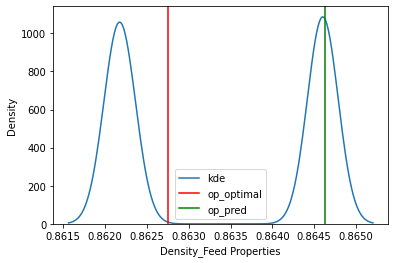

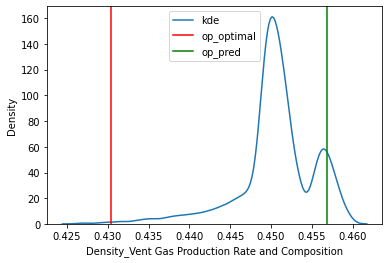

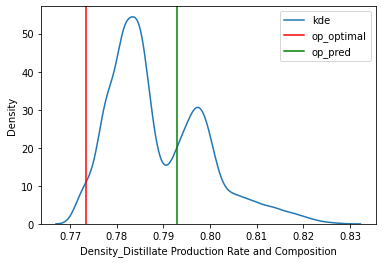

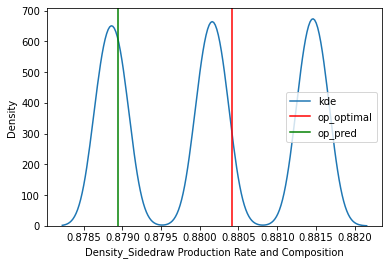

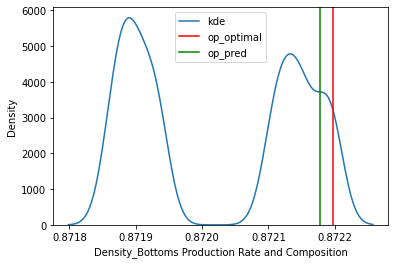

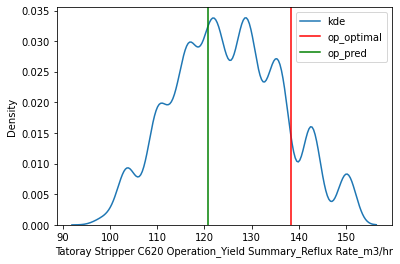

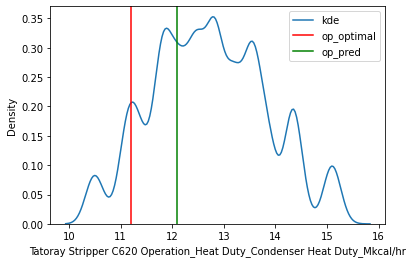

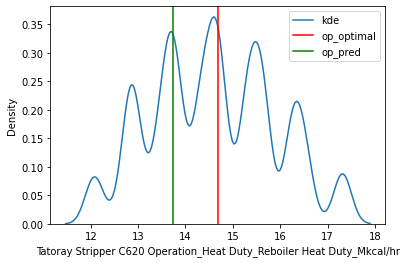

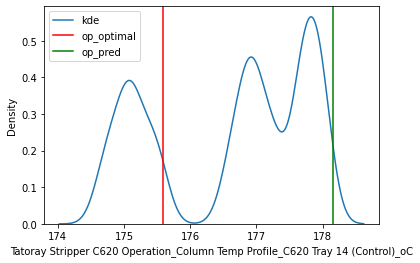

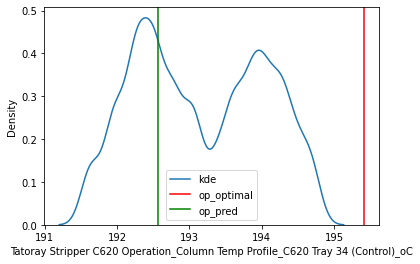

In [67]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [68]:
import joblib
G.shrink()
c620_f.shrink()
joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_G.pkl')
joblib.dump(c620_f,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c620_F.pkl']